# Рынок заведений общественного питания Москвы

Данная работа - это исследование рынка общественного питания в Москве. Основная **цель** - выявить перспективные характеристики заведения для будущего развития, например, его тип, расположение, вместимость.  

Для анализа будут использованы открытые данные о заведениях общественного питания в Москве:  

``id`` - идентификатор объекта;  
``object_name`` — название объекта общественного питания;  
``chain`` — сетевой ресторан;  
``object_type`` — тип объекта общественного питания;  
``address`` — адрес;  
``number`` — количество посадочных мест.

## Оглавление
1. [Загрузка и обработка данных](#данные)
2. [Анализ данных](#анализ)
    1. [Cоотношение видов объектов общественного питания по количеству](#количество)
    2. [Соотношение сетевых и несетевых заведений по количеству](#сеть)
    3. [Соотношение сетевых заведений по количеству посадочных мест](#места)
    4. [Распределение среднего количества посадочных мест в зависимости от типа заведения](#ср_места)
    5. [Определение улиц и районов с наибольшим и наименьшим числом заведений](#улица)
3. [Общий вывод и презентация](#вывод)

## Загрузка и обработка данных <a name='данные'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [4]:
df = pd.read_csv('rest_data.csv')
df.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
df.isnull().sum() # проверка на наличие пропусков

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [5]:
df.duplicated().sum() # проверка на наличие дубликатов

0

В таблице отсутствуют пропуски и полные дубликаты, однако есть строки, где названия заведений написаны заглавными буквами. Скорее всего, могут встречаться дублирующие строки с другим написанием. Приведем все названия к одному регистру - первая буква заглавная, далее строчная. Ковычки тоже следует удалить.

In [6]:
df['object_name'] = df['object_name'].str.capitalize() # приводим к одному регистру

In [7]:
# удаление ковычек
df['object_name'] = df['object_name'].str.replace('»', '')
df['object_name'] = df['object_name'].str.replace('«', '')

В исходных данных есть названия с указанием типа заведения, например: "Шоколадница" и "Кофейня шоколадница". Оставим только названия заведений. Для строк, у которых в названии было указано только "Кафе" или "Столовая" заменим их на "No name".

In [8]:
name = ['Кафе', 'Кофейня', 'Кальянная', 'Столовая', 'Бар', 'Ресторан']

for word in name:
    for object_name in df['object_name']:
        if word in object_name:
            df['object_name'] = df['object_name'].str.replace(word, '')

In [9]:
df['object_name'] = df['object_name'].replace('', 'No name')

Снова приведем все названия к нужному регистру.

In [10]:
df['object_name'] = df['object_name'].str.lstrip()
df['object_name'] = df['object_name'].str.capitalize()

Названия сетей тоже написаны по-раному. Приведем к единому стилю самые популярные.

In [11]:
names_dict = {
    'Теремок': ['Теремок', 'теремок'],
    'Kfc': ['Kfc', 'kfc', 'кфс', 'Кфс'],
    'Папа джонс': ['Папа джонс', 'папа джонс'],
    'Крошка картошка': ['Крошка картошка', 'крошка картошка'],
    'Му-му': ['Му-му', 'му-му'],
    'Starbucks': ['Starbucks', 'Старбакс', 'старбакс', 'starbucks'],
    'Кружка': ['Кружка', 'кружка'],
    'Мята lounge': ['Мята lounge', 'мята lounge', 'Мята Lounge', 'мята Lounge'],
    'Макдоналдс': ['Макдоналдс', 'макдоналдс', 'Mcdonalds', 'mcdonalds', 'McDonalds'],
    'Шоколадница': ['Шоколадница', 'шоколадница'],
    'Бургер кинг': ['Бургер кинг', 'Burger King', 'burger king', 'Burger king']
}

index = 0
for object_name in df['object_name']:
    for key in names_dict:
        for name in names_dict[key]:
            if name in object_name:
                df.loc[index, 'object_name'] = key
    index += 1

Посмотрим на аномалии в других стобцах

In [12]:
df['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [13]:
df['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Для удобства размещения на графиках заменим предприятие быстрого обслуживания на другое название

In [14]:
df['object_type'] = df['object_type'].str.replace('предприятие быстрого обслуживания', 'фастфуд')

In [15]:
df[df['number'] < 0]

,id,object_name,chain,object_type,address,number


Теперь можно удалить дубликаты. Так как несмотря на совпадение названий и адресов, тип заведения может отличаться (буфет при столовой), как и количество посадочных мест, отнесем к дубликатам строки с совпадающими названиями, расположением и типом. Наиболее актуальной будет информация с максимальным id.

In [16]:
df = df.sort_values(by='id', ascending=False) # сортировка по убыванию id

In [17]:
duplicated = df[df[['object_name', 'address', 'object_type']].duplicated()] # таблица с дубликатами

In [18]:
df = df.loc[~df['id'].isin(duplicated['id'])]

In [19]:
df

,id,object_name,chain,object_type,address,number
13580,223439,Донер кебаб,нет,фастфуд,"город Москва, Ленинский проспект, дом 39/1",0
14317,223438,Тандыр хачапури,нет,фастфуд,"город Москва, Ломоносовский проспект, дом 23А",3
14293,223437,Шаурма,нет,фастфуд,"город Москва, Ломоносовский проспект, владение...",0
14307,223436,Донер кебаб,нет,фастфуд,"город Москва, Ломоносовский проспект, дом 19А",0
14629,223435,Magic,нет,фастфуд,"город Москва, Болотниковская улица, дом 12",6
...,...,...,...,...,...,...
6787,19619,-фитнес,нет,бар,"город Москва, Пятницкое шоссе, дом 29, корпус 5",24
1558,19618,Галладенс,нет,кафе,"город Москва, Мичуринский проспект, дом 21, ко...",25
3404,19613,Азбука вкуса,да,бар,"город Москва, Мичуринский проспект, дом 22, ко...",6
3290,5882,Эссе,нет,кафе,"город Москва, Никитинская улица, дом 13А",70


В данном разделе привели названия заведений к одному образцу, удалили дубликаты по названию и адресу. Убедились, что нет пропусков и других аномальных значений.

## Анализ данных <a name='анализ'></a>

#### Cоотношение видов объектов общественного питания по количеству <a name='количество'></a>

Text(0.5, 0, 'Тип заведения')

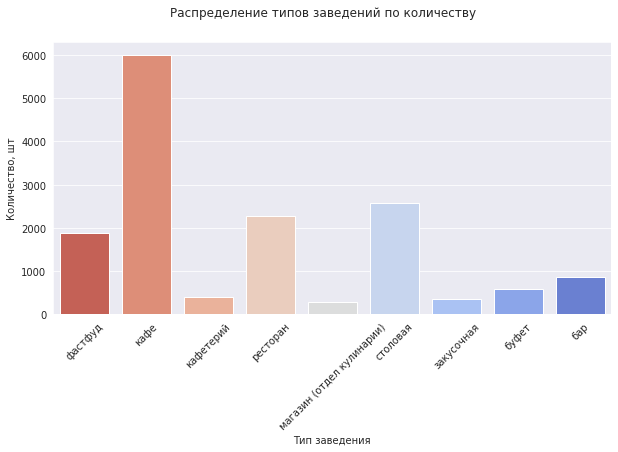

In [20]:
sns.set_style(style="darkgrid")
plt.rcParams['figure.figsize']=10,5
plt.xticks(rotation=45)
sns.countplot(x='object_type', data=df, palette='coolwarm_r')
plt.suptitle('Распределение типов заведений по количеству')
plt.ylabel('Количество, шт')
plt.xlabel('Тип заведения')

В Москве больше всего заведений типа "кафе", причем количество организаций следующего по популярности типа "столовая" меньше более чем в 2 раза. Реже всего в Москве можно встретить магазин (с отделом кулинарии), закусочную или кафетерий. Скорее всего это связано с некой иерархией заведений, где самое престижное место занимает ресторан. Для получения этого статуса, заведению необходимо соблюдать высокие стандарты кухни и обслуживания, что проблемно при большой сети. Далее следует кафе, меню которого меньше и требования ниже, что позволяет строить сетевой бизнес, а разновидностей кафе гораздо больше, чем других заведений (детское кафе, молодежное, арт-кафе). Столовая - это, обычно, предприятие обслуживающее конкретную группу людей (учащиеся, работники). Существуют и самостоятельные, основной упор делается на скорость обслуживания, а меню "на каждый день". Все остальные категории обладают небольшим меню. <a name="график"></a>

#### Соотношение сетевых и несетевых заведений по количеству <a name='сеть'></a>

In [21]:
'{:.2%}'.format(df[df['chain'] == 'да']['id'].count() / df[df['chain'] == 'нет']['id'
        ].count())

'24.00%'

Text(0.5, 0, 'Тип заведения')

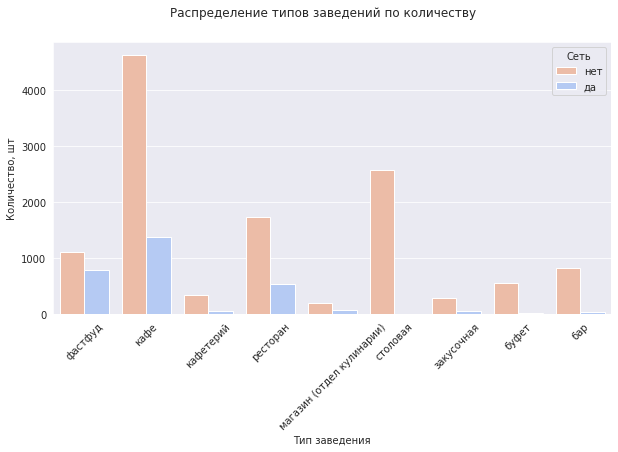

In [22]:
plt.xticks(rotation=45)
sns.countplot(x='object_type', hue='chain', data=df,
              palette='coolwarm_r')
plt.legend(title='Сеть')
plt.suptitle('Распределение типов заведений по количеству')
plt.ylabel('Количество, шт')
plt.xlabel('Тип заведения')

Больше всего сетевых заведений типа "кафе". Однако, если посмотреть какую долю занимают сетевые заведения в общем количестве организаций определенного типа, то можно сказать, что сетевое распространение характерно для предприятий быстрого обслуживания. 
Также, стоит обратить внимание, что среди столовых вообще нет сетей, ведь как уже было отмечено выше, они чаще всего прикреплены к предприятиям или учебным заведениям. В целом, доля сетевых предприятий общественного питания составляет чуть больше 24%.

#### Соотношение сетевых заведений по количеству посадочных мест <a name='места'></a>

In [23]:
df_chain = df[df['chain'] == 'да']

Text(0.5, 0, 'Количество посадочных мест, шт')

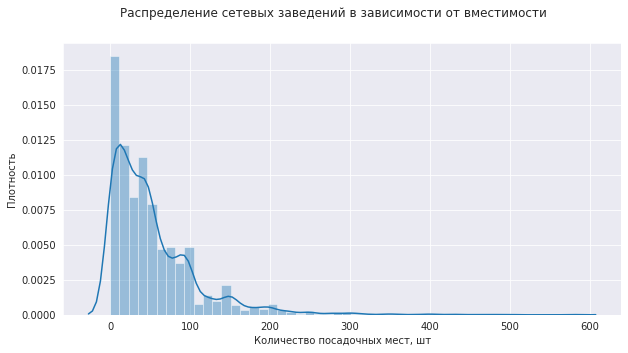

In [24]:
sns.distplot(df_chain['number'])
plt.suptitle('Распределение сетевых заведений в зависимости от вместимости')
plt.ylabel('Плотность')
plt.xlabel('Количество посадочных мест, шт')

Если рассматривать сетевые заведения в общем, то видно, что по количеству преобладают заведения с небольшим количеством мест. Посмотрим на распределение по каждой сети отдельно на графике совместного распределения .

In [25]:
chain = df_chain.groupby('object_name')[['number']].agg(['count', 'mean'
        ])
chain.columns = ['count', 'mean']

Text(0.5, 1.07, 'Распределение сетевых заведений в зависимости от вместимости')

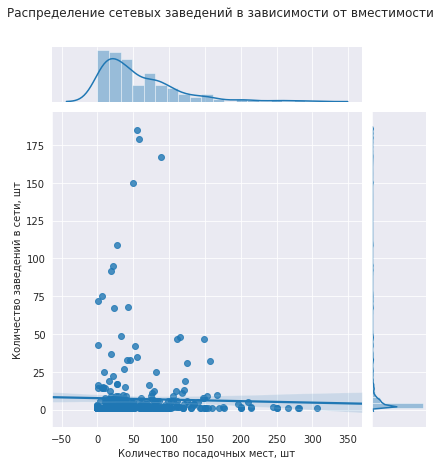

In [26]:
sns.jointplot(data=chain, x='mean', y='count', kind='reg'
              ).set_axis_labels('Количество посадочных мест, шт',
                                'Количество заведений в сети, шт'
                                )
plt.suptitle('Распределение сетевых заведений в зависимости от вместимости'
             , y=1.07)

График показывает, что для сетей более распространен принцип "Больше заведений, меньше посадочных мест". Как видно из графика ["Распределение типов заведений по количеству"](#график), сетевое развитие более характерно для предприятий быстрого обслуживания, где мест вообще может не быть (стритфуд), а главное в работе - скорость. Соответственно у таких заведений нет интереса в долгом прибывании гостя. Это подтверждает и практика, например, сеть Макдональдс известна своими "уловками" для того чтобы посетители тратили меньше времени на прибывание там - неудобная мебель и ее расположение, ритмичная музыка, нарушение личного пространства и т.д.

#### Распределение среднего количества посадочных мест в зависимости от типа заведения <a name='ср_места'></a>

Text(0.5, 0, 'Тип заведения')

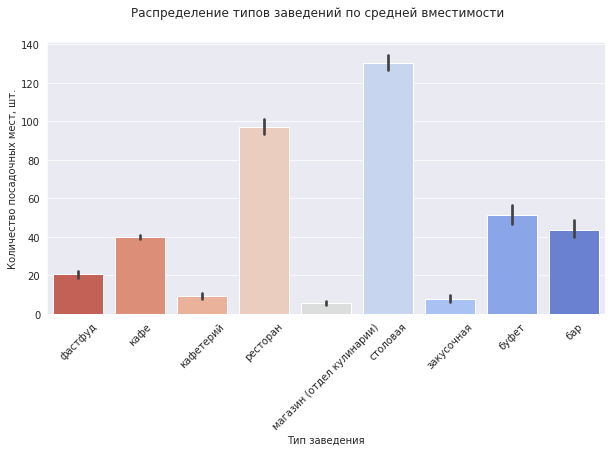

In [27]:
plt.xticks(rotation=45)
sns.barplot(x="object_type", y="number", data=df, 
            palette='coolwarm_r')
plt.suptitle('Распределение типов заведений по средней вместимости')
plt.ylabel('Количество посадочных мест, шт.')
plt.xlabel('Тип заведения')

Можно выделить 3 группы по среднему количеству посадочных мест:  
1. Небольшая вместимость (до 20 мест) у фастфуда, кафетерия, магазина с отделом кулинарии и закусочной.  
2. Среднее количество мест (от 20 до 50) в кафе, буфете и баре.  
3. Самая большая вместимость у столовой и ресторана.  
Посмотрим на диаграмму размаха, для наглядности ограничем ось y.

Text(0.5, 0, 'Тип заведения')

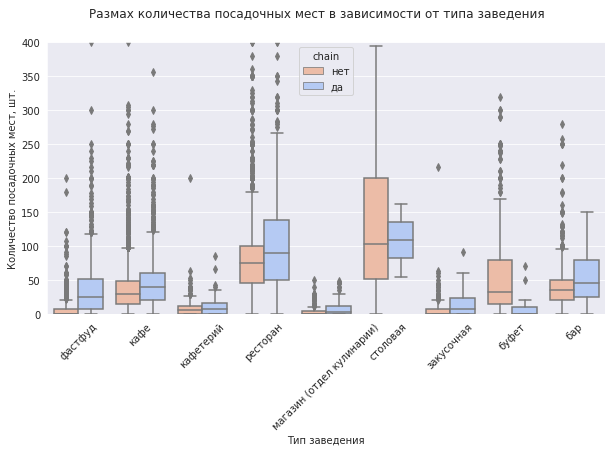

In [28]:
plt.xticks(rotation=45)
sns.boxplot(x="object_type", y="number", data=df, hue="chain", 
            palette='coolwarm_r')
plt.ylim(0,400)
plt.suptitle('Размах количества посадочных мест в зависимости от типа заведения')
plt.ylabel('Количество посадочных мест, шт.')
plt.xlabel('Тип заведения')

В среднем, столовая обладает большей вместимостью, второе место занимает ресторан. По диаграмме размаха можно отметить, что, как правило, в сетевых заведениях мест больше, чем в заведениях того же типа, но не сетевых. Посмотрим на месторасположение.

#### Определение улиц и районов с наибольшим и наименьшим числом заведений <a name='улица'></a>

In [29]:
# включаем в регулярное выражение значения для фильтрации
filter_regex = 'город|корпус|дом|строение|поселение|владение|посёлок|сооружение|Олимпийская|деревня|ж/к|село|дачный|рабочий'

def filter_address(filter_regex, col_name):
    # делаем из адреса датафрейм с его частями
    split_address = df[col_name].str.split(', ', expand=True)

    # проходимся циклом по всем столбцам и заменяем ячейки, включающие ненужные значения, на пустые значения
    for col in split_address.columns:
        split_address.loc[split_address[col].str.match(filter_regex, na=False,
                  case=False), col] = None

    # обратно соединяем в новый столбец куски адреса без ненужных частей
    df['street'] = split_address.apply(lambda x: x.str.cat(sep=', ',
                                   join='left'), axis=1)

    # изучаем значения с запятыми — там могли остаться ненужные части адреса; добавляем их в фильтр
    df.loc[df['street'].str.contains(','), 'street'].unique()
    
filter_address(filter_regex, 'address')

В датафрейме присутствуют адреса без улиц, а только с названиями населенных пунктов. Заменим появившиеся пробелы на эти названия.

In [30]:
filter_regex = 'город Москва|город Троицк|корпус|поселение|дом|строение|сооружение|владение'
df.loc[df['street'] == '', 'street'] = df.loc[df['street'] == '',
        'address']
filter_address(filter_regex, 'street')
df.loc[df['street'].str.contains(','), 'street'].unique()

array(['Киевское шоссе, 22-й километр',
       'Новорижское шоссе, 22-й километр', 'МКАД, 44-й километр',
       'Калужское шоссе, 22-й километр', 'Киевское шоссе, 23-й километр',
       'Калужское шоссе, 20-й километр', 'Киевское шоссе, 21-й километр',
       'Калужское шоссе, 47-й километр', 'Киевское шоссе, 28-й километр',
       'Варшавское шоссе, 28-й километр',
       'Варшавское шоссе, 27-й километр', 'Киевское шоссе, 32-й километр',
       'Киевское шоссе, 39-й километр', 'Киевское шоссе, 37-й километр',
       'Боровское шоссе, 29-й километр', 'Калужское шоссе, 43-й километр'],
      dtype=object)

In [31]:
# сгруппируем по названию улиц и найдем количество заведений для улиц и среднее количество посадочных мест
street = df.groupby('street')[['number']].agg(['count', 'mean'
        ]).reset_index()
street.columns = ['street', 'object_count', 'number_mean']

In [32]:
# топ-10 улиц
top_street = street.query('street != "город Зеленоград"'
                          ).sort_values(by='object_count',
        ascending=False).head(10)

Text(0.5, 0, 'Улица')

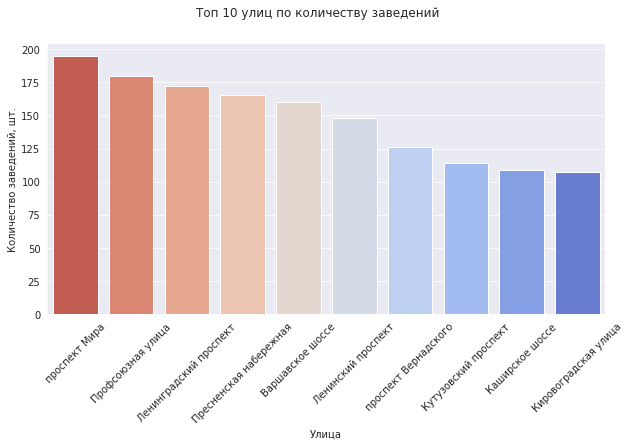

In [33]:
plt.xticks(rotation=45)
sns.barplot(x='street', y='object_count', data=top_street, 
            palette='coolwarm_r')
plt.suptitle('Топ 10 улиц по количеству заведений')
plt.ylabel('Количество заведений, шт.')
plt.xlabel('Улица')

На графике представлены улицы с наибольшим количеством заведений. Можно отметить, что все улицы имеют большую протяженность, кроме Пресненской набережной, на которой расположен международный деловой центр «Москва-Сити».

In [34]:
# датафрейм с районами и улицами
area = pd.read_csv('https://raw.githubusercontent.com/Distans/temp/main/mosgaz-streets.csv')

In [35]:
area.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [36]:
top_area = top_street.merge(area, left_on='street', right_on='streetname')

In [37]:
top_area

,street,object_count,number_mean,streetname,areaid,okrug,area
0,проспект Мира,195,62.312821,проспект Мира,70,СВАО,Алексеевский район
1,проспект Мира,195,62.312821,проспект Мира,86,СВАО,Ярославский Район
2,проспект Мира,195,62.312821,проспект Мира,78,СВАО,Район Марьина роща
3,проспект Мира,195,62.312821,проспект Мира,79,СВАО,Останкинский район
4,проспект Мира,195,62.312821,проспект Мира,81,СВАО,Район Ростокино
5,проспект Мира,195,62.312821,проспект Мира,82,СВАО,Район Свиблово
6,проспект Мира,195,62.312821,проспект Мира,16,ЦАО,Мещанский район
7,Профсоюзная улица,180,47.761111,Профсоюзная улица,123,ЮЗАО,Академический район
8,Профсоюзная улица,180,47.761111,Профсоюзная улица,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,180,47.761111,Профсоюзная улица,134,ЮЗАО,Район Ясенево


За редким исключением, все районы расположены в пределах МКАД, чаще между 3-м Транспортным Кольцом и МКАД.

In [38]:
# улицы с 1 заведением
low_street = street[street['object_count'] == 1]

In [39]:
low_area = low_street.merge(area, left_on='street',
                            right_on='streetname')

In [40]:
low_area['area'].value_counts().head(10)

Таганский район        27
Район Хамовники        26
Басманный район        25
Пресненский район      20
Тверской район         20
Район Марьина роща     18
Район Арбат            18
Мещанский район        16
Район Сокольники       15
Район Замоскворечье    14
Name: area, dtype: int64

Исходя из полученных результатов, можно сделать вывод:  
Много заведений находятся на улицах с большой протяженностью, между МКАД и ТТК. Улицы с 1 заведением небольшие, их много и находятся они в центре города, однако, несмотря на то, что заведение на улице всего одно, для посетителя не будет проблемой выбрать другое место в переделах района, так что это не сказывается на конкуренции.

In [41]:
low_street['object_count'].count()

600

Общее число улиц с одним заведением - 600. Если посмотреть на топ 10 районов по количеству входящих в них улиц с одним заведением, то можно отметить высокую плотность застройки и малоэтажность, что не позволяет размещать крупные торговые центры, которые имеют много точек общественного питания. 

Text(0.5, 1.07, 'Распределение заведений в зависимости от вместимости')

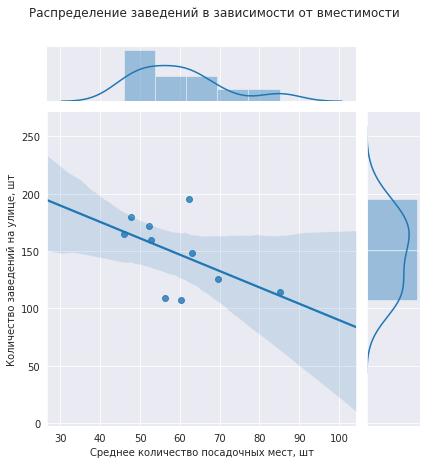

In [42]:
sns.jointplot(x='number_mean', y='object_count', data=top_street,
              kind='reg'
              ).set_axis_labels('Среднее количество посадочных мест, шт',
                                'Количество заведений на улице, шт'
                                )
plt.suptitle('Распределение заведений в зависимости от вместимости',
             y=1.07)

Количество заведений и среднее кол-во посадочных мест в них имеют обраную связь.

In [43]:
name_str = top_street['street']
df_top = df.query('street in @name_str') # датафрейм с иформацией о заведениях на улицах из топ-10

Text(0.5, 0, 'Количество посадочных мест, шт')

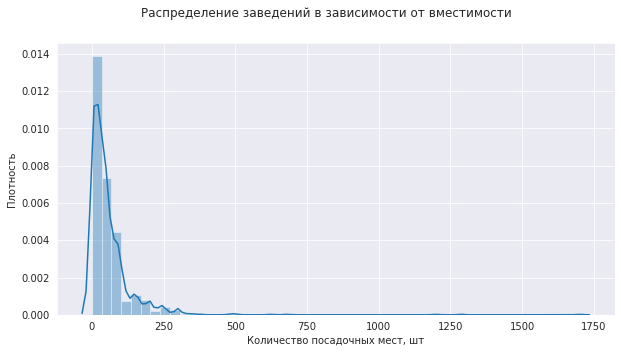

In [44]:
sns.distplot(df_top['number'])
plt.suptitle('Распределение заведений в зависимости от вместимости')
plt.ylabel('Плотность')
plt.xlabel('Количество посадочных мест, шт')

Оба этих графика демонстрируют следующую тенденцию: "Больше заведений, меньше посадочных мест".

## Общий вывод <a name='вывод'></a>

На первом этапе работы данные были подготовленны к анализу, большая часть посвящена обработке некорректных названий, а именно: приведение к одному стилю написания и, для крупных сетей, замена имен на правильные. Затем поиск и удаление дубликатов.  
Анализ начался с оценки соотношения количества объектов с их типом. В Москве больше всего заведений типа "кафе", причем количество организаций следующего по популярности типа "столовая" меньше более чем в 2 раза. Реже всего в Москве можно встретить магазин (с отделом кулинарии), закусочную или кафетерий. Это связано с тем, что статус "кафе" не обременяет владельцев придерживаться таких строгих стандартов как для заведения типа "ресторан", однако позволяет иметь широкое меню и эксперементировать с интерьером, атмосферой, кухней и т.д. Отсюда столько разновидностей кафе - детское, арт, молодежное и пр. Кроме того, следующий этап анализа показал, что сетевых заведений дянного типа больше всего. Однако, если смотреть на соотношение сетевых заведений к общему количеству, то для предприятий быстрого обслуживания сетевое распространение более характерно. Для них действует принцип: "Больше заведений, меньше мест". Это позволяет облужить большой поток людей и охватить большую географию. Если смотреть на распределение среднего количества посадочных мест, то особо выделяется "столовая". Чаще всего предприятия данного типа находятся при каких-либо учебных заведениях или местах работы. Тут тоже важна скорость обслуживания как у фастфуда (котрые часто вообще не имеют посадочных мест), однако учитывая меню и тот факт, что обеденный перерыв у работников или учащихся примерно в одно время, столовые должны вмещать всех. Далее были выделены улицы с наибольшем количеством заведений и наименьшим. Больше всего мест общественного питания на самых протяженных улицах, т.е. в районе между Мкадом и 3-м Транспортным кольцом. Улицы, где можно найти только 1 заведение располагаются в центре города, что тоже связано с их размером. Но нельзя на основе этого сделать вывод о конкуренции по районам, ведь 1 улица с множеством заведений может охватывать сразу 3 района, в то время как 1 район в центре может вмещать в себя почти 30 небольших улиц с 1 заведением на каждой.  

Общие рекомендации с учетом конкурентного приемущества:  
1. Наиболее подходящий тип заведения - "кафе". Предполагается, что гостей будут обслуживать официанты-роботы, соответственно невозможно будет соблюдать стандарты сервиса ресторана или обеспечить высокую скорость столовой или фастфуда. Но данный формат отлично подойдет для кафе.  
2. При выборе количества посадочных мест стоит учитывать количество персонала, в том числе скорость обслуживания роботов-официантов при полной посадке. Нормальная вместимость для типа "кафе" от 20 до 40 мест.  
3. Так как один из рисков для заведения - потеря интереса к роботам, рекомендую выбирать расположение с учетом туристической привлекательности, т.е. это скорее небольшие улочки в центре или места близь объектов туристического притяжения.  
4. Так как проект требует большого объема инвестиций, рекомендую принимать решение о сетевом развитии на основе результатов работы первого заведения.  

Презентацию о результатах работы можете найти <a href="https://www.canva.com/design/DAEUWNjJrKU/VSStPxJ3aw8vqx8S-rZa2w/view?utm_content=DAEUWNjJrKU&utm_campaign=designshare&utm_medium=link&utm_source=sharebutton">здесь</a>.